# Analysis of the autism data

Template exp:
Records n 7 

In [717]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# 1) Results and subgroups analysis

#### Functions definition

In [603]:
from model.xgboost.visualization import plot_roc_curves_xgboost
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
pd.set_option('display.max_rows', 1000)
def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)

    performances_dict = {'name':name+'\n(N='+str(len(y_true))+')', 
                         'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Corrected NPV': round(npv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn,
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==0), np.sum(y_true==1)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df


def plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False, savefig=False):
    
    colors = plt.get_cmap('tab10')(np.arange(0,20))

    
    if xtickslabels is None:
        xtickslabels = sorted(results[condition].unique())
        
    if order is None:
        order = sorted(results[condition].unique())
        
    else:
        xtickslabels = order


    fig = plt.figure(figsize=(15, 5));ax = plt.gca()
    # loop over the curves (i.e. the metrics to be plotted)
    for j, metric_name in enumerate(results['metric_name'].unique()):

        color = colors[j]
        # loop over the x ticks  (i.e. the condition that is varying)
        for i, condition_value in enumerate(order):

            plt.errorbar([i], 
                         results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].mean(),
                         yerr=results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].std(), 
                         fmt='',
                         ecolor=color,#'grey',
                        # ecolor=color,
                         alpha=.5, 
                         capthick=1,
                         elinewidth=3,
                         capsize=6)
            plt.scatter([i], 
                         results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].mean(),
                         marker='o',
                         s=50,
                         label=metric_name if i==0 else None, color=color)

    plt.grid(); plt.title("Performances when using or not the inidcator variables", weight='bold')
    #plt.ylabel(metric_name, weight='bold');
    plt.xlabel(condition, weight='bold');plt.xlim([-1, len(results[condition].unique())]); plt.ylim([-0.02, 1.02])
    plt.xticks(np.arange(len(results[condition].unique())), xtickslabels, rotation=90 if rotate else 0);#plt.legend()
    #plt.xticks([])
    #plt.legend()
    if savefig:
        os.makedirs(os.path.join(ROOT_DIR, 'figures'), exist_ok=True)
        plt.savefig(os.path.join(ROOT_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')
            


    #fig = plt.figure(figsize=(25, 5));ax = plt.gca()
    #ax = sns.pointplot(data=results, x=condition, y="relative_score", hue='metric_name', hue_order=results['metric_name'].unique(), ci='sd', linestyles='-', ax = ax)
    #ax.set_title("Performances gain", weight='bold')
    #ax.axhline([0], color='tab:red', linestyle='-.');ax.legend(prop={'size':18})
    
    return

def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
def select(df, feat, value):
    return df[df[feat]==value]  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Figure: Influence of the set of variables used

## Gathering the different subgroups results

In [483]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['19_december_features_experiment_with_weight'])#'13_november_bis'])#'November 2022'])
df['Hanley_CI'] = df['AUROC'] .apply(lambda x: compute_SD(x, 417, 50))
df['tree_usage'] = df['tree_usage'].apply(lambda x: np.mean(x))
pi = df.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df['NPV Corr'] = df.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)
#df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_asd_nt_all_variables.csv', index=False)


100%|██████████| 701/701 [02:40<00:00,  4.36it/s]


In [596]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'Hanley_CI', 'optimal_threshold'])

metrics_of_interest = ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr', 'TP', 'TN', 'FP', 'FN', 'Hanley_CI']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV','PPV-Corr', 'NPV', 'NPV Corr']#, 'Precision Corrected']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV', 'NPV']#, 'Precision Corrected']


for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'], 
                                                                       'optimal_threshold': experiment_row['optimal_threshold']
                                                                      }, ignore_index=True)
        
results_df_vertical.loc[results_df_vertical['metric_name']!='AUROC', 'Hanley_CI'] = 0

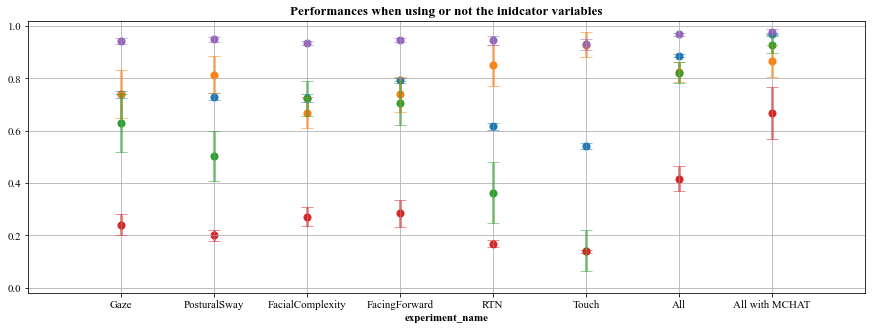

In [604]:
results = results_df_vertical[(results_df_vertical['experiment_name'].str.contains('Multimodal')) & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results['experiment_name'] = results['experiment_name'].apply(lambda x: x.replace('Multimodal ', ''))
results['experiment_name'] = results['experiment_name'].replace({name: name.replace('-', 'but\n') if '-' in name else 
                                                                 name.replace('but', 'but\n') if 'but' in name else 
                                                                 name.replace('but', 'but\n') for name in results['experiment_name'].unique()})
results['experiment_name'].unique()
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

results['experiment_name'].unique()
for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['experiment_name']=='All') & (results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
order_multimodal = ['All', 'All - Gaze', 'All - RTN', 'All - PosturalSway', 'All - Touch', 'Gaze', 'RTN', 'PosturalSway', 'Touch']
order_multimodal = ['Gaze', 'PosturalSway', 'FacialComplexity', 'FacingForward', 'RTN', 'Touch', 'All', 'All but\n Gaze', 'All but\n PosturalSway', 'All but\n FacialComplexity', 'All but\n FacingForward', 'All but\n RTN', 'All but\n Touch', 'All with MCHAT']
order_multimodal = ['Gaze', 'PosturalSway', 'FacialComplexity', 'FacingForward', 'RTN', 'Touch', 'All', 'All with MCHAT']


condition = 'experiment_name'
plot_scatter_results(results[results['experiment_name'].isin(order_multimodal)], condition, xtickslabels=None, order=order_multimodal, rotate=False, savefig='features_comparison')
    

In [309]:
results.groupby(['experiment_name', 'metric_name']).describe()['score']

count      mean       std       min       25%       50%       75%       max
experiment_name            metric_name                                                                             
All                        AUROC         50.0  0.887020  0.006570  0.875000  0.882250  0.888500  0.890750  0.904000
                           NPV           50.0  0.969520  0.005273  0.958000  0.966250  0.970500  0.973000  0.981000
                           NPV Corr      50.0  0.995128  0.000867  0.993255  0.994596  0.995278  0.995774  0.997015
                           PPV           50.0  0.417240  0.048324  0.312000  0.384250  0.415000  0.444000  0.549000
                           PPV-Corr      50.0  0.101420  0.019019  0.066000  0.088250  0.099500  0.110750  0.159000
                           Sensitivity   50.0  0.825760  0.037318  0.735000  0.796000  0.837000  0.857000  0.898000
                           Specificity   50.0  0.822940  0.039767  0.704000  0.796000  0.823000  0.847250  0.909000
All but\n FacialComplexity AUROC         50.0  0.873020  0.009063  0.847000  0.868000  0.873000  0.876750  0.900000
                           NPV           50.0  0.964200  0.008483  0.943000  0.958250  0.962500  0.970750  0.980000
                           NPV Corr      50.0  0.994240  0.001390  0.990746  0.993313  0.993940  0.995296  0.996859
                           PPV           50.0  0.397960  0.059892  0.304000  0.359250  0.396000  0.419500  0.600000
                           PPV-Corr      50.0  0.095020  0.023504  0.064000  0.080000  0.092500  0.100750  0.189000
                           Sensitivity   50.0  0.795220  0.060569  0.633000  0.755000  0.786000  0.837000  0.898000
                           Specificity   50.0  0.811500  0.054945  0.695000  0.778750  0.817000  0.845000  0.927000
All but\n FacingForward    AUROC         50.0  0.876560  0.009125  0.843000  0.870250  0.878000  0.882000  0.894000
                           NPV           50.0  0.960280  0.005810  0.942000  0.957000  0.960500  0.963750  0.973000
                           NPV Corr      50.0  0.993592  0.000986  0.990430  0.993063  0.993639  0.994181  0.995625
                           PPV           50.0  0.421460  0.052759  0.344000  0.384250  0.416500  0.446750  0.579000
                           PPV-Corr      50.0  0.103300  0.021458  0.076000  0.088250  0.099500  0.111750  0.176000
                           Sensitivity   50.0  0.766620  0.044990  0.633000  0.755000  0.776000  0.796000  0.857000
                           Specificity   50.0  0.837500  0.039281  0.756000  0.811750  0.836500  0.860000  0.927000
All but\n Gaze             AUROC         50.0  0.870540  0.008150  0.847000  0.866000  0.870000  0.876000  0.886000
                           NPV           50.0  0.963940  0.009505  0.950000  0.956000  0.962500  0.970750  0.987000
                           NPV Corr      50.0  0.994202  0.001566  0.991902  0.992862  0.994025  0.995385  0.997982
                           PPV           50.0  0.376580  0.051312  0.287000  0.336000  0.375500  0.419000  0.473000
                           PPV-Corr      50.0  0.087100  0.017446  0.059000  0.073000  0.085500  0.101000  0.123000
                           Sensitivity   50.0  0.797180  0.066353  0.694000  0.735000  0.796000  0.852000  0.939000
                           Specificity   50.0  0.793860  0.060889  0.659000  0.749250  0.803500  0.848000  0.881000
All but\n PosturalSway     AUROC         50.0  0.891040  0.007412  0.874000  0.887000  0.891000  0.895750  0.907000
                           NPV           50.0  0.969660  0.004881  0.960000  0.966000  0.970000  0.973750  0.979000
                           NPV Corr      50.0  0.995148  0.000790  0.993533  0.994591  0.995159  0.995825  0.996615
                           PPV           50.0  0.461600  0.044515  0.366000  0.426750  0.475000  0.492500  0.544000
                           PPV-Corr      50.0  0.118840  0.018661  0.082000  0.103500  0.123500 

**Creation of the final model to perfrom the subgroup analysis**

In [821]:
df_subgroup_analysis = deepcopy(df[df['experiment_name']=='Multimodal All'])

In [822]:
use_weight = True
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df_autism =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df_autism, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='Final', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'Multimodal All',
                  verbosity=1, 
                  save_experiment=False)

random_state=np.random.randint(1000)
#exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
#exp.predictions_df['sample_weight'] = weighted_confidence_score
#exp.plot()

**Initialize the result dataframe**

In [829]:
results = None
for i, row in df_subgroup_analysis.iterrows():
    
    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(row['y_true'])/row['num_samples'], np.sum(row['y_true'][0] == 0), np.sum(row['y_true'][0] == 1))

    
    res = compute_results(y_true, y_pred, optimal_threshold, name="All", title=title)
    if results is not None:
        results = results.append(res)
    else:
        results = res
    

**Ablation per sex**

In [830]:
for sex, sex_encoding in zip(['Male', 'Female'], [0, 1]):#[0,1]):
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(exp.dataset.df[exp.dataset.df['sex']==sex_encoding].index)
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=sex, title=title)
        results = results.append(res)

**Ablation per race and ethnicity**

In [831]:
exp.dataset.df.loc[exp.dataset.df['race'].isnull(), 'race'] = -1
for race, race_encoding in zip(['White/Caucasian', 'Black/African American', 'Other'], [0,1, 2]):
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(exp.dataset.df[exp.dataset.df['race']==race_encoding].index)
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=race, title=title)
        results = results.append(res)
        
    
        
for ethnicity, ethnicity_encoding in zip(['Not Hispanic/Latino', 'Hispanic/Latino'], [0,1]):
    
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(exp.dataset.df[exp.dataset.df['ethnicity']==ethnicity_encoding].index)
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=ethnicity, title=title)
        results = results.append(res)    
    

**Ablation per age**

In [832]:
age_bins = [[17, 21], [21, 25], [25, 29], [29, 36], [36, 50]]
age_bins = [[17, 18.5], [18.5, 24], [24, 37]]


exp.dataset.df['age_bin'] = np.nan
for (low_age, high_age) in age_bins:
    
    age_name = 'Age (Months)\n{}-{}'.format(low_age, high_age)
    exp.dataset.df.loc[(exp.dataset.df['age'] >= low_age) & (exp.dataset.df['age'] < high_age), 'age_bin'] = age_name
    
    
for age_bin in exp.dataset.df['age_bin'].unique():
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(exp.dataset.df[exp.dataset.df['age_bin']==age_bin].index)
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=str(age_bin), title=title)
        results = results.append(res)    
    

**Ablation per Mchat results**

In [833]:

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_final'].isnull()].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='No MCHAT', title=title)
    results = results.append(res)    

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 0].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='MCHAT Negative',title=title)
    results = results.append(res)    


for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 1].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='MCHAT Positive', title=title)
    results = results.append(res)    


**Based on Conclusiveness**

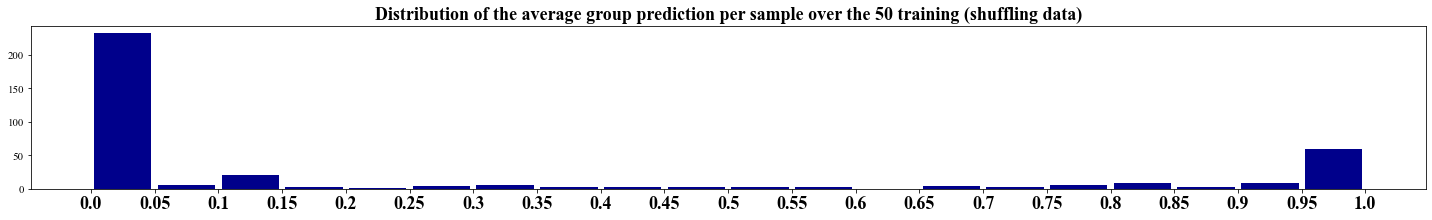

In [834]:
    
conslusiveness_score = []
for i, row in df_subgroup_analysis.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

  
fi(25, 3)
plt.hist(conslusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 50 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

# Inconclusive
for th in [0.05, 0.1, 0.15, 0.2]:
    
    for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conslusiveness_score > th) & (conslusiveness_score< 1-th)).flatten()
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name="Inconclusive ({})".format(th), title=title)
        results = results.append(res)    
        
        
# Conclusive
for th in [0.05, 0.1, 0.15, 0.2]:
    
    for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)).flatten()
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name="Conclusive ({})".format(th), title=title)
        results = results.append(res)    

**Based on missing variables**

In [835]:
X  = pd.DataFrame(exp.dataset._X_train, columns=exp.features_name)
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
exp.dataset.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

grouped_missing_features = {k: [v] for k, v in feature_name_mapping.items()}

for mdp in sorted(exp.dataset.df["mdp"].unique()):
    
    d = deepcopy(exp.dataset.df[exp.dataset.df["mdp"] == mdp])
    
    if len(d)/len(exp.dataset.df)*100 > 5:
        print(mdp, "{:.2f} %".format(len(d)/len(exp.dataset.df)*100))
        print("\n".join(d[exp.features_name].columns[d[exp.features_name].isna().any()].tolist()))
mapping_name = {0: "Complete", 
                10: "Only game missing", 
                12: "Game and Delay missing", 
                3: "Only delay missing"}
               # 11: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

for mdp_index in mapping_name.keys():
    for i, row in df_subgroup_analysis.iterrows():

        index_subgroup = np.array(exp.dataset.df[exp.dataset.df["mdp"] == mdp_index].index)

        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

        res = compute_results(y_true, y_pred, optimal_threshold, name= mapping_name[mdp_index],title=title)
        results = results.append(res)    



0 49.07 %

3 13.79 %
average_response_to_name_delay
10 19.36 %
pop_rate
std_error
average_length
average_force_applied
12 8.22 %
average_response_to_name_delay
pop_rate
std_error
average_length
average_force_applied


**Results for administrations having a compliance higher than .75**

In [836]:
exp.sample_weight = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))


In [837]:
for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(np.argwhere(exp.sample_weight >=.75).flatten())

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name= 'Conclusive\nAdministrations',title=title)
    results = results.append(res)    


for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(np.argwhere(exp.sample_weight < .75).flatten())

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name= 'Inconclusive\nAdministrations',title=title)
    results = results.append(res)    



## Analysis of the results

**Creation of the vertical dataframe**

In [838]:
results['correction_factor'] = results.apply(lambda x: (np.mean(x['y_true'])*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-np.mean(x['y_true']))), axis=1)
results['NPV-Corr'] = results.apply(lambda x: (x['correction_factor']*x['TN'])/(x['correction_factor']*x['TN']+x['FN']+1e-5), axis=1)

final_results = deepcopy(results)
final_results['y_true'] = list(final_results['y_true'])
final_results['y_pred'] = list(final_results['y_pred'])

#final_results.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_asd_nt_subgroups.csv', index=False)


In [839]:
final_results.reset_index(inplace=True)
final_results.rename(columns={'Sensitivity, recall, hit rate, or true positive rate (TPR)':'Sensitivity', 
                       'Specificity, selectivity or true negative rate (TNR)':'Specificity', 
                       'Corrected Precision or positive predictive value (PPV)':'PPV-Corr', 
                       'Precision or positive predictive value (PPV)': 'PPV', 
                              'Negative predictive value (NPV)': 'NPV'
                              
                       }, inplace=True)

final_results.rename(columns={'index': 'subgroup'}, inplace=True)
final_results['subgroup_name'] = final_results['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])


results_vertical = pd.DataFrame(columns = ['subgroup', 'score', 'metric_name'])#, 'TP', 'TN', 'FP', 'FN', 'N'])

metrics_of_interest =['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'PPV-Corr', 'NPV', 'NPV-Corr']
metrics_to_plot = ['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'PPV-Corr', 'NPV', 'NPV-Corr']

for _, experiment_row in final_results.iterrows():
    
    pi = row['y_true'][0].mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

    
    for metric in metrics_of_interest:
        
        results_vertical = results_vertical.append(pd.DataFrame({'subgroup':experiment_row['subgroup'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'FN':experiment_row['FN'], 
                                                                       'N': experiment_row['N'], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'],
                                                                       'y_true': [experiment_row['y_true']],
                                                                       'y_pred': [experiment_row['y_pred']]
                                                                      }, index=[0]))
        
results_vertical.reset_index(drop=True, inplace=True)
results_vertical['subgroup_name'] = results_vertical['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])
results_vertical['N'] = results_vertical['N'].astype(int)
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

In [840]:
results_vertical['subgroup_raw'].unique()

array(['All', 'Male', 'Female', 'White/Caucasian',
       'Black/African American', 'Other', 'Not Hispanic/Latino',
       'Hispanic/Latino', 'Age (Months)\n24-37', 'Age (Months)\n18.5-24',
       'Age (Months)\n17-18.5', 'No MCHAT', 'MCHAT Negative',
       'MCHAT Positive', 'Inconclusive (0.05)', 'Inconclusive (0.1)',
       'Inconclusive (0.15)', 'Inconclusive (0.2)', 'Conclusive (0.05)',
       'Conclusive (0.1)', 'Conclusive (0.15)', 'Conclusive (0.2)',
       'Complete', 'Only game missing', 'Game and Delay missing',
       'Only delay missing', 'Conclusive\nAdministrations',
       'Inconclusive\nAdministrations'], dtype=object)

**Plot results per subgroups**

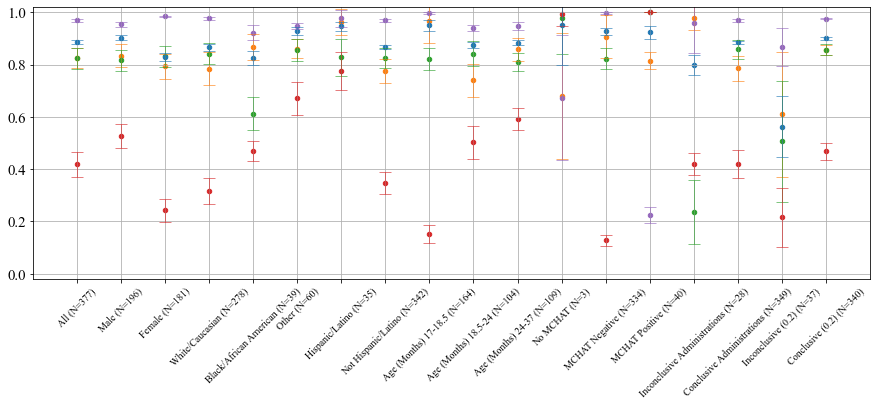

In [843]:
colors = plt.get_cmap('tab10')(np.arange(0,20))
rotate=1
savefig="Subgroups_analysis"
plt.rcParams["font.family"] = "Times New Roman"

condition = 'subgroup_raw'

order = ['All', 'Male', 'Female', 
         'White/Caucasian',
       'Black/African American', 'Other',
       'Hispanic/Latino',  'Not Hispanic/Latino',
         'Age (Months)\n17-18.5','Age (Months)\n18.5-24', 'Age (Months)\n24-37', 
        'No MCHAT', 'MCHAT Negative',
       'MCHAT Positive', 
        # 'Complete', 'Only game missing', 'Game and Delay missing', 'Only delay missing',
       'Inconclusive\nAdministrations', 'Conclusive\nAdministrations', 
         'Inconclusive (0.2)','Conclusive (0.2)']


xtickslabel = []
fig = plt.figure(figsize=(15, 5));ax = plt.gca()
# loop over the curves (i.e. the metrics to be plotted)
for j, metric_name in enumerate([ 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUROC']):
    
    color = colors[j+1] if j!= 4 else colors[0]
    # loop over the x ticks  (i.e. the condition that is varying)
    for i, condition_value in enumerate(order):

        plt.errorbar([i], 
                     results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].mean(),
                     yerr=results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].std(), 
                     fmt='',
                     ecolor=color,
                    # ecolor=color,
                     alpha=.6, 
                     capthick=1,
                     elinewidth=1,
                     capsize=6)
        plt.scatter([i], 
                     results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].mean(),
                     marker='o',
                     s=20,
                     label=metric_name if i==0 else None, color=color)
        if j ==0:
            xtickslabel.append(results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['subgroup'].iloc[0].replace("\n", " "))

plt.grid(); #plt.title("Performances when using or not the inidcator variables", weight='bold')
#plt.ylabel(metric_name, weight='bold');
#plt.xlabel(condition, weight='bold');
plt.xlim([-1, len(xtickslabel)]); plt.ylim([-0.02, 1.02])
plt.xticks(np.arange(len(xtickslabel)), xtickslabel, rotation=45 if rotate else 0, fontsize=10);
plt.yticks( fontsize=15);

#plt.legend(prop={'size':20})
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'subgroup_results.png'), dpi=200, bbox_inches = 'tight')

In [855]:
pd.set_option('display.max_rows', None)
results_vertical.groupby(['subgroup', 'metric_name']).describe()

score                                                                          TP                                                     TN                                                            FP                                                      FN                                                  N                                                Hanley_CI                                                                      
                                                  count      mean       std       min       25%       50%       75%       max count   mean       std   min    25%   50%    75%   max count    mean        std    min     25%    50%     75%    max count   mean        std   min    25%   50%    75%   max count  mean       std  min   25%  50%    75%   max count   mean  std    min    25%    50%    75%    max     count      mean       std       min       25%       50%       75%       max
subgroup                              metric_name                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Age (Months)\n17-18.5\n(N=164)        AUROC        50.0  0.949740  0.022056  0.860000  0.945500  0.954000  0.962000  0.970000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0  130.66   6.781156  112.0  126.00  130.0  136.00  143.0  50.0  28.34   6.781156  16.0  23.00  29.0  33.00  47.0  50.0  0.16  0.421852  0.0  0.00  0.0   0.00   2.0  50.0  164.0  0.0  164.0  164.0  164.0  164.0  164.0      50.0  0.024897  0.008394  0.016648  0.020053  0.023378  0.026835  0.058053
                                      NPV          50.0  0.998740  0.003343  0.984000  1.000000  1.000000  1.000000  1.000000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0  130.66   6.781156  112.0  126.00  130.0  136.00  143.0  50.0  28.34   6.781156  16.0  23.00  29.0  33.00  47.0  50.0  0.16  0.421852  0.0  0.00  0.0   0.00   2.0  50.0  164.0  0.0  164.0  164.0  164.0  164.0  164.0      50.0  0.024897  0.008394  0.016648  0.020053  0.023378  0.026835  0.058053
                                      NPV-Corr     50.0  0.999070  0.002480  0.987924  1.000000  1.000000  1.000000  1.000000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0  130.66   6.781156  112.0  126.00  130.0  136.00  143.0  50.0  28.34   6.781156  16.0  23.00  29.0  33.00  47.0  50.0  0.16  0.421852  0.0  0.00  0.0   0.00   2.0  50.0  164.0  0.0  164.0  164.0  164.0  164.0  164.0      50.0  0.024897  0.008394  0.016648  0.020053  0.023378  0.026835  0.058053
                                      PPV          50.0  0.152280  0.034938  0.073000  0.129000  0.147000  0.179000  0.238000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0  130.66   6.781156  112.0  126.00  130.0  136.00  143.0  50.0  28.34   6.781156  16.0  23.00  29.0  33.00  47.0  50.0  0.16  0.421852  0.0  0.00  0.0   0.00   2.0  50.0  164.0  0.0  164.0  164.0  164.0  164.0  164.0      50.0  0.024897  0.008394  0.016648  0.020053  0.023378  0.026835  0.058053
                                      PPV-Corr     50.0  0.117720  0.028095  0.055000  0.098750  0.113000  0.139000  0.188000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0  130.66   6.781156  112.0  126.00  130.0  136.00  143.0  50.0  28.34   6.781156  16.0  23.00  29.0  33.00  47.0  50.0  0.16  0.421852  0.0  0.00  0.0   0.00   2.0  50.0  164.0  0.0  164.0  164.0  164.0  164.0  164.0      50.0  0.024897  0.008394  0.016648  0.020053  0.023378  0.026835  0.058053
                                      Sensitivity  50.0  0.968000  0.084370  0.600000  1.000000  1.000000  1.000000  1.000000  50.0   4.84  0.421852   3.0   5.00   5.0   5.00   5.0  50.0

# Plot AUROC for certain experiemnts

In [536]:
columns_of_interest = ['y_true', 'y_pred', 'optimal_threshold', 'AUROC']

In [578]:

d1 = df[df['experiment_name']=='Multimodal All'].sort_values('AUROC').iloc[25:26][columns_of_interest]
d1['name'] = 'All'
sd1 = df[df['experiment_name']=='Multimodal All']['AUROC'].std()

d2 = df[df['experiment_name']=='Multimodal All with MCHAT'].sort_values('AUROC').iloc[25:26][columns_of_interest]
d2['name'] = 'All+MCHAT R/F'
sd2 = df[df['experiment_name']=='Multimodal All with MCHAT']['AUROC'].std()


In [579]:
from utils import create_autism_df


df_nt_ddld = create_autism_df(folder_names = ['21_December_Final_With_Weight_ddld_nt'])#'13_november_bis'])#'November 2022'])
pi = df_nt_ddld.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df_nt_ddld['NPV Corr'] = df_nt_ddld.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)

d3 = df_nt_ddld.sort_values('AUROC').iloc[25:26][columns_of_interest]
d3['name'] = 'LD/DD vs NT'
sd3 = df_nt_ddld['AUROC'].std()





df_nt_ddld_asd = create_autism_df(folder_names = ['21_December_Final_With_Weight_ddld+asd_nt'])#'13_november_bis'])#'November 2022'])
pi = df_nt_ddld_asd.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df_nt_ddld_asd['NPV Corr'] = df_nt_ddld_asd.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)

d4 = df_nt_ddld_asd.sort_values('AUROC').iloc[25:26][columns_of_interest]
sd4 = df_nt_ddld_asd['AUROC'].std()
d4['name'] = 'Autistic+LD/DD vs NT'

100%|██████████| 51/51 [00:16<00:00,  3.11it/s]


In [590]:
(d2.iloc[0]['y_true'][0]==0).sum()


328

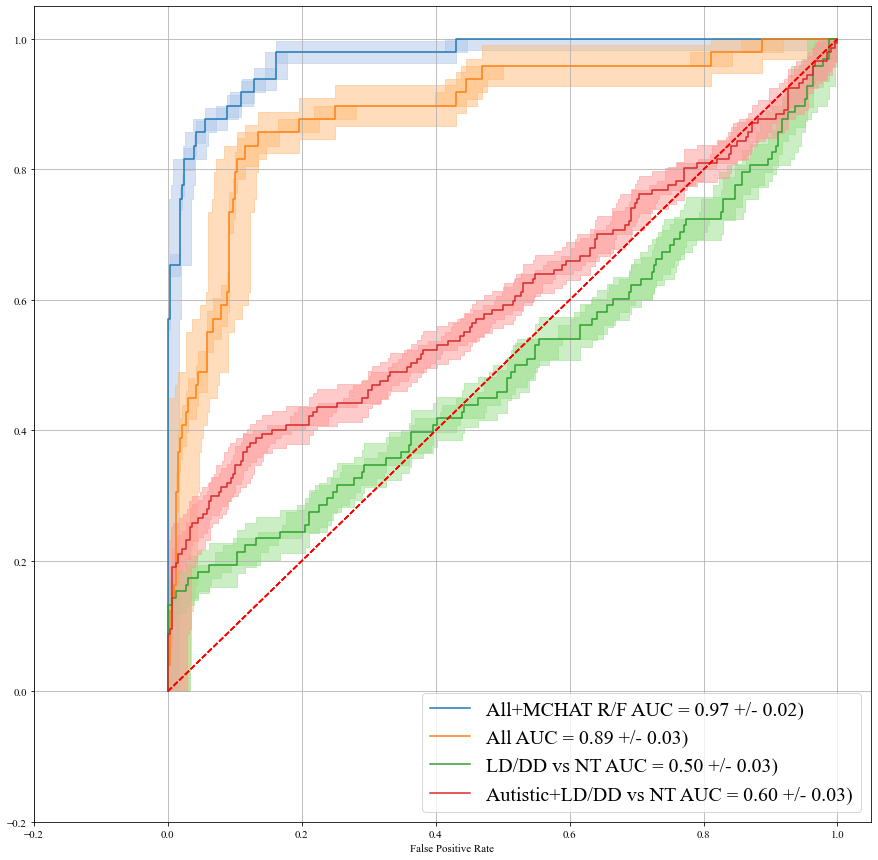

In [624]:
colors = plt.get_cmap('tab20')(np.arange(0,20))
fig, axes = plt.subplots(1, 1, figsize=(15, 15));axes = [axes]
name='All'
fprs = []
tprs  =[] 
i=0
for i, (dataframe, sd) in enumerate(zip([d2, d1, d3, d4], [sd1, sd2, sd3, sd4])):
            
    row = dataframe.iloc[0]

    # ROC CURVE
    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    


    fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
    
    sd = compute_SD(roc_auc, np.sum(y_true==1), np.sum(y_true==0))

    axes[0].plot(fpr, tpr, '-', lw=1.5, color=colors[2*i],  label='{} AUC = {:.2f} +/- {:.2f})'.format(row['name'], roc_auc, sd))
    axes[0].plot([0, 1], [0, 1], color='red', lw=1.5, linestyle='--')
    axes[0].set_xlim([0.0, 1.0]); axes[0].set_ylim([0.0, 1.05]);
    axes[0].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

    tprs_upper = np.minimum(tpr + sd, 1);tprs_lower = np.maximum(tpr - sd, 0)
    axes[0].fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.5)

    fpr_upper = np.minimum(fpr + sd, 1);fpr_lower = np.maximum(fpr - sd, 0)
    axes[0].fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.5)

    #idx_threshold = np.argmin(np.abs(thresholds - row['optimal_threshold']))
    #axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)

    axes[0].grid('on'); #axes[0].axis('off')
    axes[0].set_xlim(-.2, 1.05)
    axes[0].set_ylim(-.2, 1.05)
    axes[0].legend(loc='lower right', prop={'size':20})
    #axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'AUROC.png'), dpi=200, bbox_inches = 'tight')

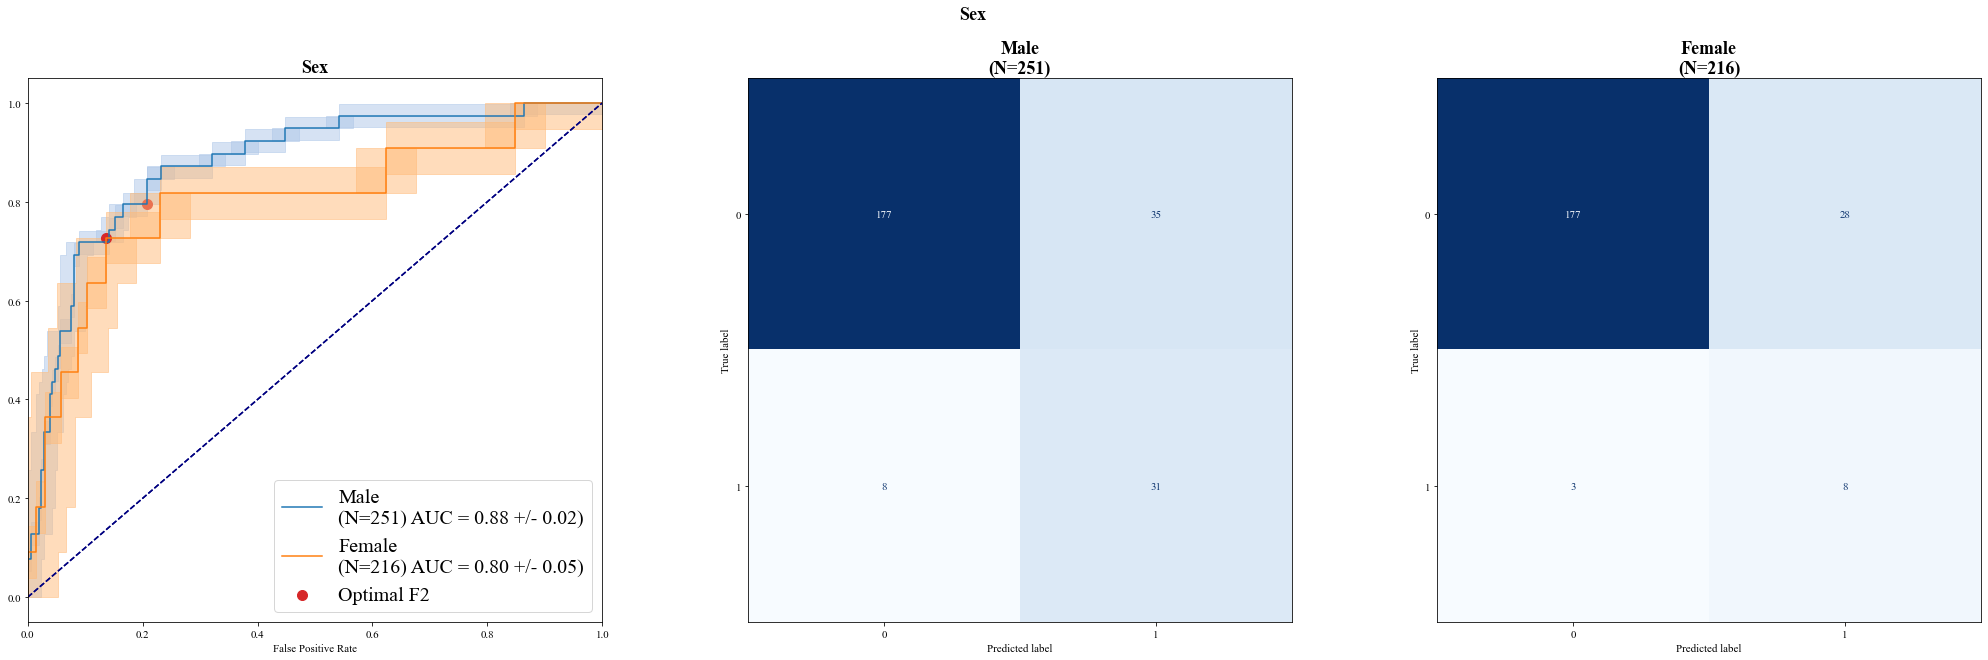

In [132]:
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

condition = 'subgroup_name'
colors = plt.get_cmap('tab20')(np.arange(0,20))

for comparisons_name, comparisons in zip(['Sex'],
                                         
                                         [['Male', 'Female']] ):
    
    d = results_vertical[results_vertical['subgroup_raw'].isin(comparisons)]
        
    fig, axes = plt.subplots(1, len(comparisons)+1, figsize=(35, 10))
    fig.suptitle(comparisons_name, weight='bold', fontsize=18)
    for i, comp in enumerate(comparisons):
        row = d[d['subgroup_raw'] == comp].iloc[0]
        
        
        # ROC CURVE
        y_true = row['y_true']
        y_pred = row['y_pred']


        fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        hanley_ci = compute_SD(roc_auc, np.sum(y_true==0), np.sum(y_true==1))

        axes[0].plot(fpr, tpr, '-', lw=1.5, label='{} AUC = {:.2f} +/- {:.2f})'.format(row['subgroup'], roc_auc, hanley_ci))
        axes[0].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes[0].set_xlim([0.0, 1.0]); axes[0].set_ylim([0.0, 1.05]); axes[0].grid()
        axes[0].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
        
        tprs_upper = np.minimum(tpr + hanley_ci, 1);tprs_lower = np.maximum(tpr - hanley_ci, 0)
        axes[0].fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.5)
        
        fpr_upper = np.minimum(fpr + hanley_ci, 1);fpr_lower = np.maximum(fpr - hanley_ci, 0)
        axes[0].fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.5)
        
        idx_threshold = np.argmin(np.abs(thresholds - exp.optimal_threshold))
        axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)
        
        axes[0].legend(loc='lower right', prop={'size':20})
        axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
        
        
        # COnfusion matrix
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]]).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes[i+1]);disp.im_.colorbar.remove()  
        axes[i+1].set_title("{}".format(row['subgroup']), weight='bold', fontsize=18)

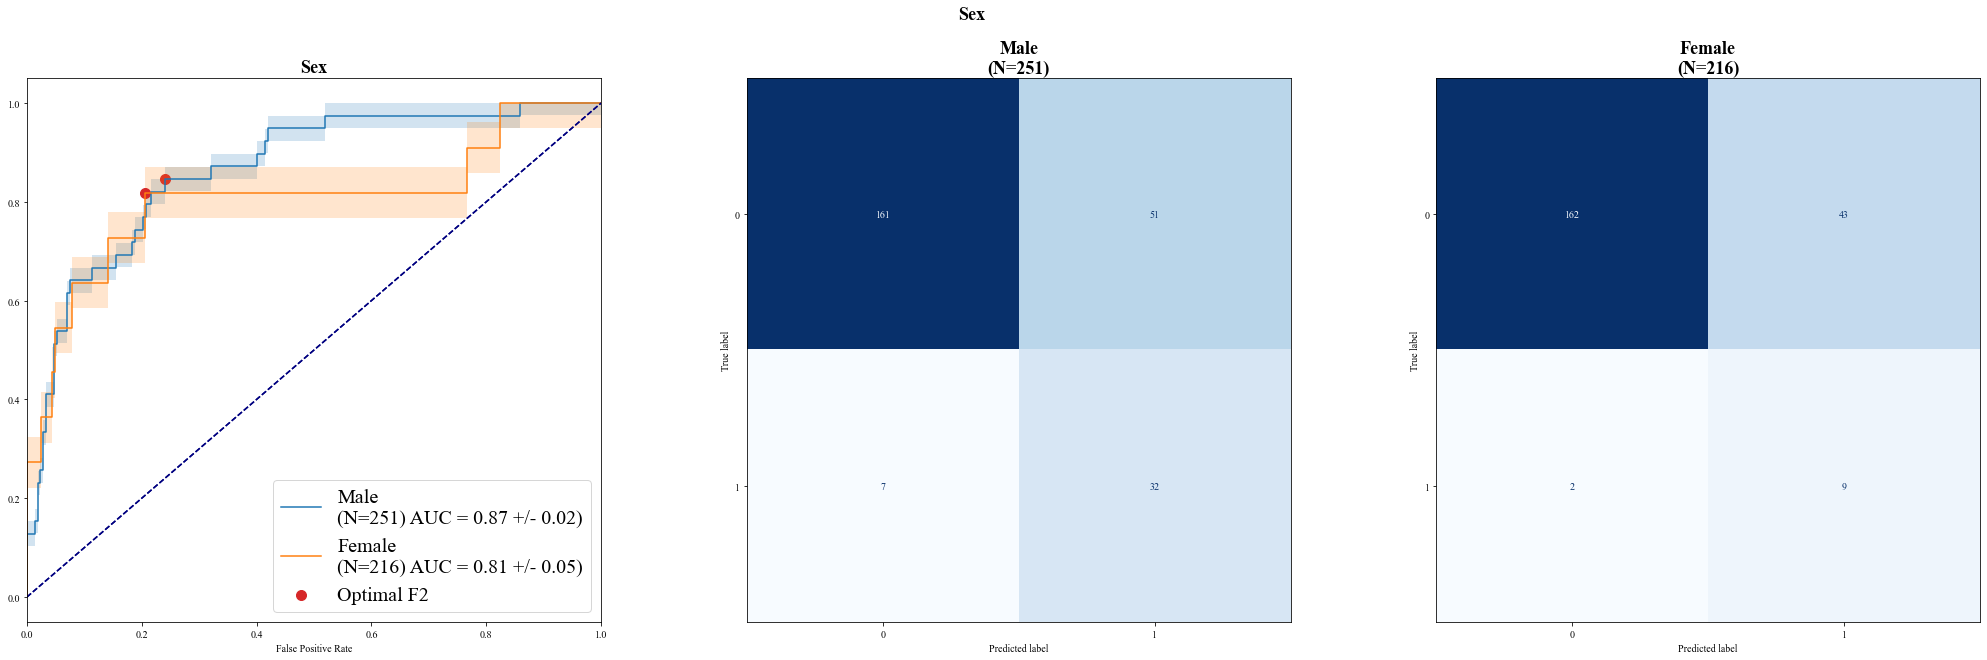

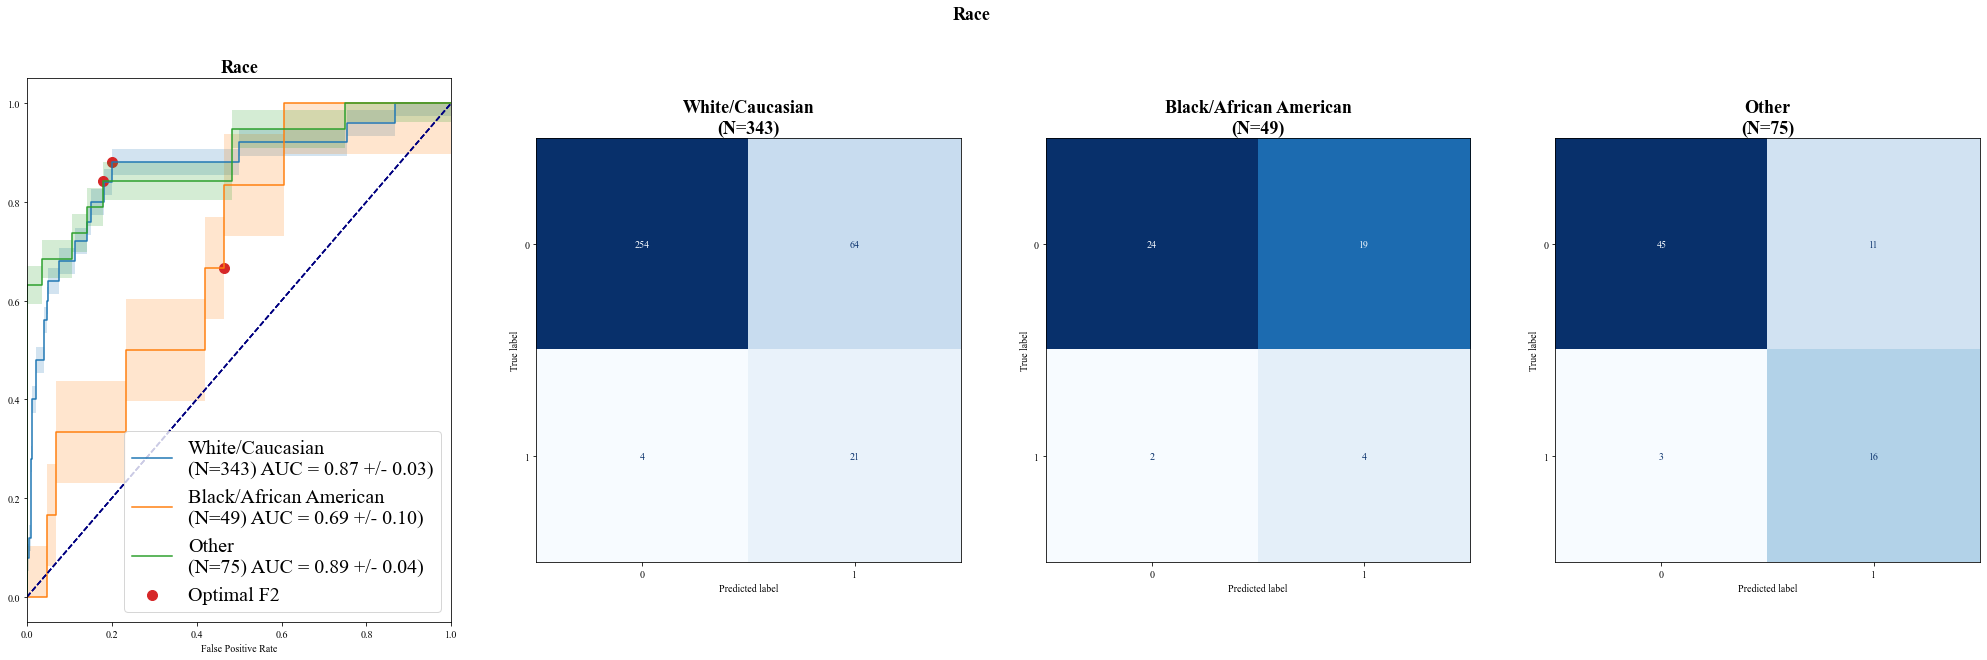

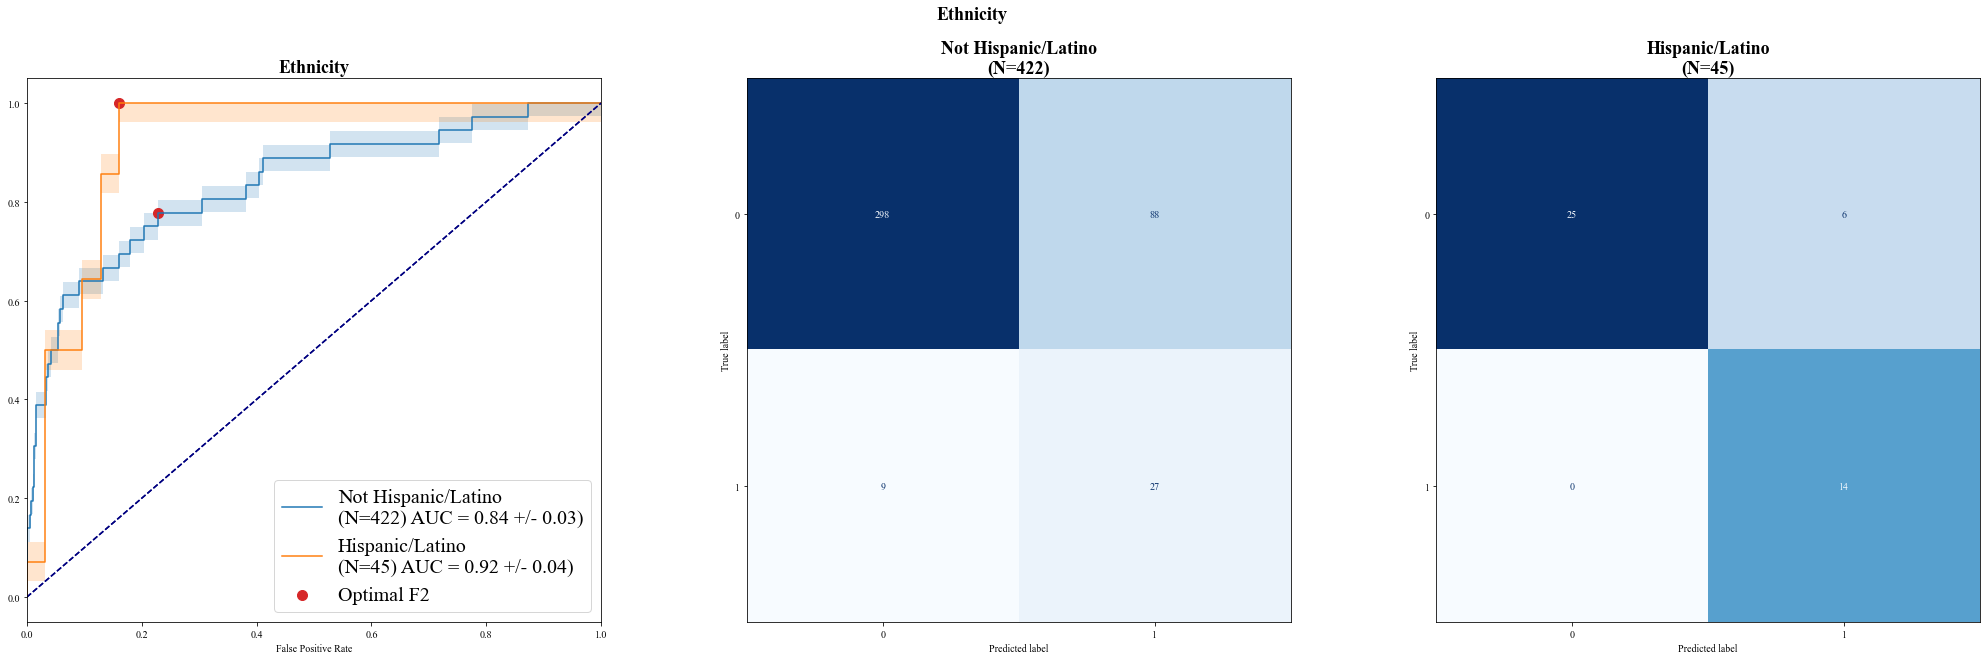

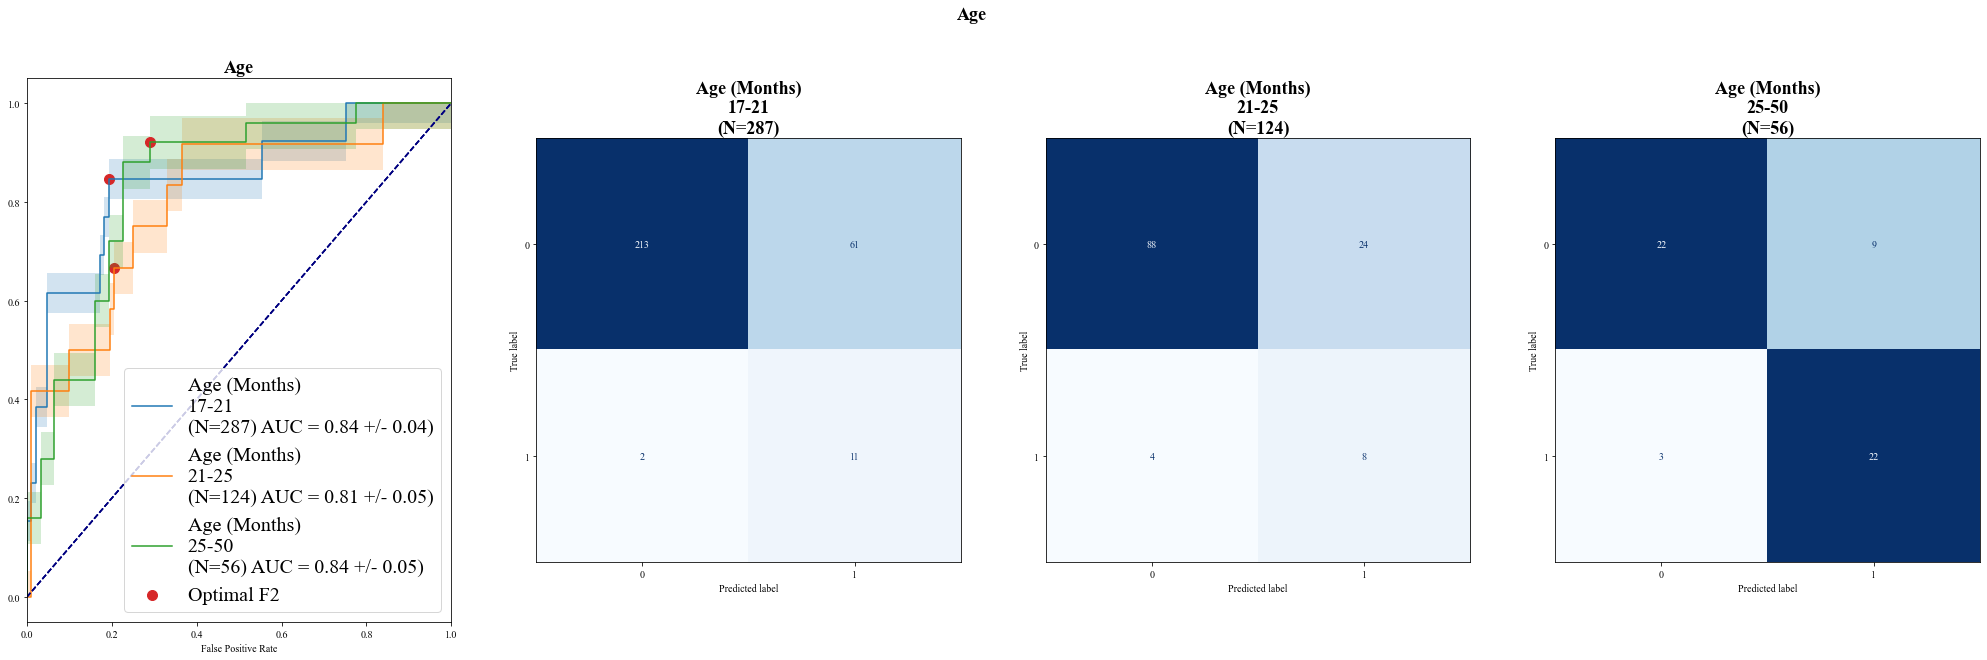

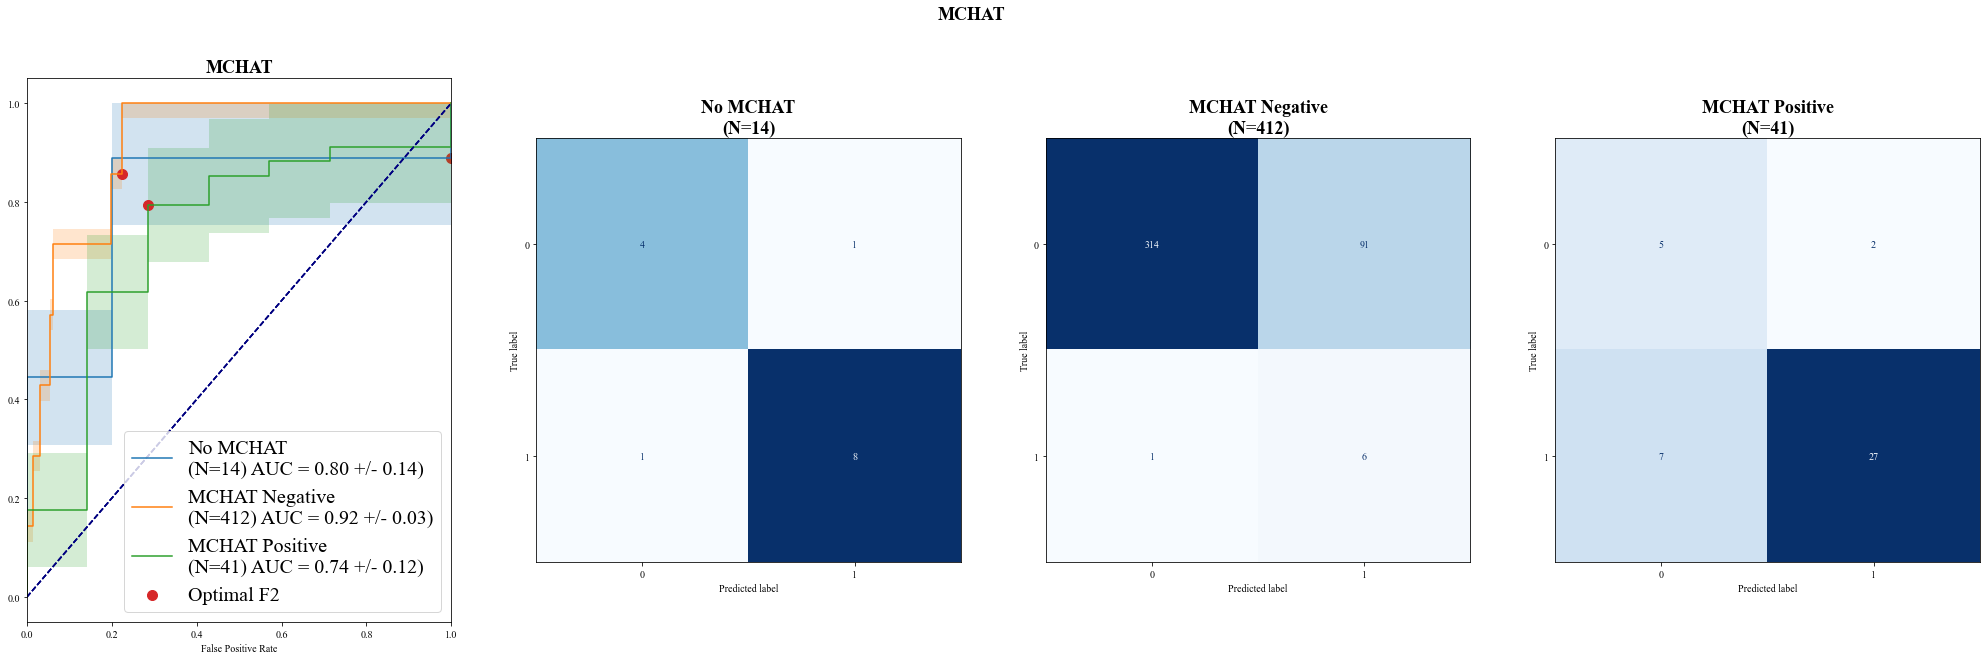

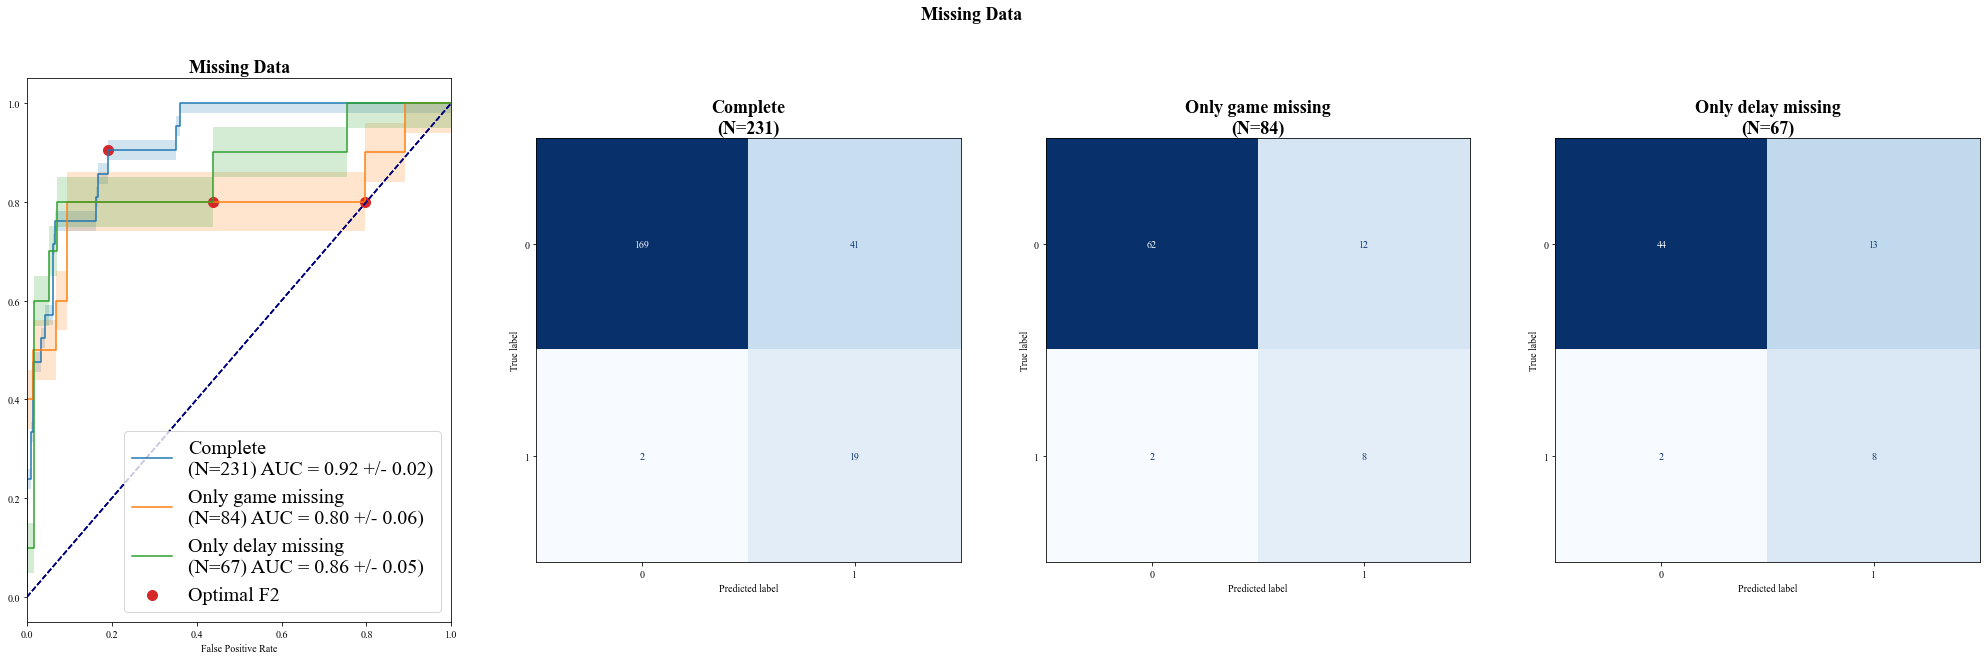

In [323]:
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

condition = 'subgroup_name'
for comparisons_name, comparisons in zip(['Sex', 'Race', 'Ethnicity', 'Age', 'MCHAT', 'Missing Data'],
                                         
                                         [['Male', 'Female'],
                                          ['White/Caucasian','Black/African American', 'Other'],
                                         ['Not Hispanic/Latino','Hispanic/Latino'], 
                                          ['Age (Months)\n17-21', 'Age (Months)\n21-25', 'Age (Months)\n25-50'],
                                          ['No MCHAT','MCHAT Negative', 'MCHAT Positive'],
                                         ['Complete', 'Only game missing','Only delay missing']] ):
    
    d = results_vertical[results_vertical['subgroup_raw'].isin(comparisons)]
        
    fig, axes = plt.subplots(1, len(comparisons)+1, figsize=(35, 10))
    fig.suptitle(comparisons_name, weight='bold', fontsize=18)
    for i, comp in enumerate(comparisons):
        row = d[d['subgroup_raw'] == comp].iloc[0]
        
        
        # ROC CURVE
        y_true = row['y_true']
        y_pred = row['y_pred']


        fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        hanley_ci = compute_SD(roc_auc, np.sum(y_true==0), np.sum(y_true==1))

        axes[0].plot(fpr, tpr, '-', lw=1.5, label='{} AUC = {:.2f} +/- {:.2f})'.format(row['subgroup'], roc_auc, hanley_ci))
        axes[0].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes[0].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes[0].grid()
        axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
        tprs_upper = np.minimum(tpr + hanley_ci, 1)
        tprs_lower = np.maximum(tpr - hanley_ci, 0)
        axes[0].fill_between(fpr, tprs_lower, tprs_upper,  alpha=.2)
        idx_threshold = np.argmin(np.abs(thresholds - exp.optimal_threshold))
        axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)
        
        axes[0].legend(loc='lower right', prop={'size':20})
        axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
        
        
        # COnfusion matrix
        cm = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]]).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes[i+1]);disp.im_.colorbar.remove()  
        axes[i+1].set_title("{}".format(row['subgroup']), weight='bold', fontsize=18)

Text(0, 0.5, 'True Positive Rate')

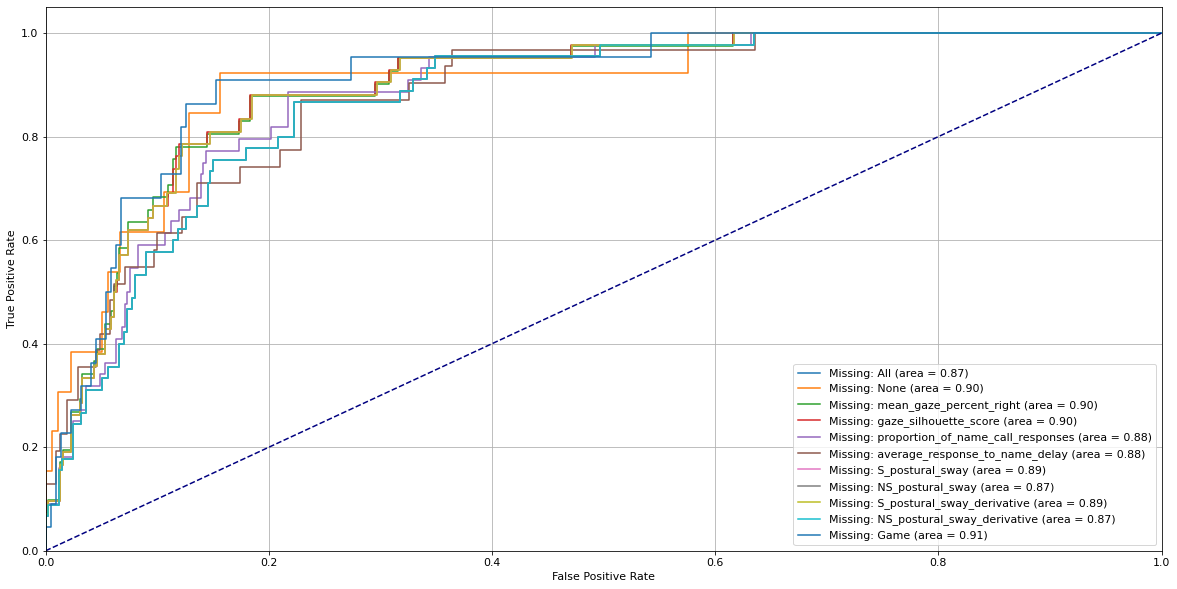

In [240]:
fig, ax =  plt.subplots(1, 1, figsize=(20, 10))


for missing, variables in grouped_missing_features.items():
    
    d=dataframe.dropna(subset=variables, how='any') 

    
    title = missing
    y_true = d['y_true'].to_numpy()
    y_pred = d['y_pred'].to_numpy()
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, '-', lw=1.5, label='Missing: {} (area = {:.2f})'.format(missing, roc_auc))


ax.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
ax.legend()
ax.set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); ax.grid()
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

In [243]:
results

,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TP_normalized,FN,FN_normalized,TN,TN_normalized,FP,FP_normalized,N
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,7.000000,11,2.000000,351,77.000000,62,14.000000,458
All,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
None,0.899,0.503,0.970,0.327,0.990,0.485,0.344,0.865,0.463,0.846,0.866,0.314,0.987,0.154,0.686,0.013,11,0.057292,2,0.010417,155,0.807292,24,0.125000,192
mean_gaze_percent_right,0.896,0.477,0.891,0.218,0.973,0.542,0.264,0.871,0.501,0.780,0.880,0.405,0.975,0.220,0.595,0.025,32,0.073733,9,0.020737,346,0.797235,47,0.108295,434
gaze_silhouette_score,0.895,0.476,0.886,0.214,0.972,0.541,0.259,0.871,0.508,0.786,0.880,0.412,0.975,0.214,0.588,0.025,33,0.075862,9,0.020690,346,0.795402,47,0.108046,435
proportion_of_name_call_responses,0.881,0.442,0.876,0.194,0.968,0.500,0.229,0.848,0.461,0.773,0.856,0.366,0.972,0.227,0.634,0.028,34,0.074890,10,0.022026,351,0.773128,59,0.129956,454
average_response_to_name_delay,0.877,0.478,0.932,0.257,0.984,0.486,0.274,0.848,0.418,0.710,0.861,0.338,0.967,0.290,0.662,0.033,22,0.064516,9,0.026393,267,0.782991,43,0.126100,341
S_postural_sway,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436
NS_postural_sway,0.873,0.430,0.872,0.187,0.967,0.482,0.217,0.841,0.443,0.756,0.850,0.354,0.970,0.244,0.646,0.030,34,0.074236,11,0.024017,351,0.766376,62,0.135371,458
S_postural_sway_derivative,0.895,0.475,0.886,0.213,0.972,0.537,0.259,0.869,0.504,0.786,0.878,0.407,0.975,0.214,0.593,0.025,33,0.075688,9,0.020642,346,0.793578,48,0.110092,436


# Further custom analysis for the paper

In [844]:
th = 0.05

    
conslusiveness_score = []
for i, row in df_subgroup_analysis.iterrows():

    y_true = row['y_true'][0]
    y_pred = row['y_pred'][0]
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)


for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)).flatten()
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name="Conclusive ({})".format(th), title=title)
        display(res)

In [856]:
th=0.2
for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)).flatten()
        
        y_true = row['y_true'][0][index_subgroup]
        y_pred = row['y_pred'][0][index_subgroup]

In [858]:
(y_true==1).sum()

43

In [849]:
np.sum(conslusiveness_score[index_subgroup] > 0.5)

78

In [859]:
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))
compute_SD(0.9, 43, 297)

0.031969496134826206

**Among the three participant without mchat, one autistic and one nt are always correlcty classified, but one is tangent and so we dive into the trianing that led to correct and incorrect classification. this could be used to label inconclusive cases**

In [742]:
cm = np.zeros((2, 2))
result_kid = []
for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_final'].isnull()].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    cm += confusion_matrix(row['y_true'][0][index_subgroup], row['y_pred'][0][index_subgroup]> row['optimal_threshold'])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap='Blues');disp.im_.colorbar.remove()  
    result_kid.append((y_pred[0] >row['optimal_threshold']).astype(int))
    
    
print(index_subgroup)
np.array(result_kid)


[ 47 244 376]


array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0])

In [792]:
conslusiveness_score = []
cm = np.zeros((2, 2))

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 0].index)

    idx_asd = np.argwhere((y_true==1)).flatten()
    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    cm += confusion_matrix(row['y_true'][0][index_subgroup], row['y_pred'][0][index_subgroup]> row['optimal_threshold'])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap='Blues');disp.im_.colorbar.remove()  
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

In [797]:
index_subgroup.shape

(334,)

In [757]:
np.array(result_kid).shape#.sum(axis=1)

(50, 334)

In [765]:
cm/(50*334)*100

array([[80.03592814, 17.26946108],
       [ 0.25149701,  2.44311377]])

In [775]:
idx_nt = np.argwhere((y_true==0)).flatten()#.sum()

In [798]:
cm

array([[13366.,  2884.],
       [   42.,   408.]])

In [796]:
th = 0.05
index_conclusive = np.argwhere((((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)) & ((y_true==0)))).flatten()

index_conclusive.shape

(249,)

In [803]:
(conslusiveness_score[index_conclusive] > 0.5).sum()

24

In [804]:
24 / len(conslusiveness_score[index_conclusive])

0.0963855421686747

In [805]:
len(conslusiveness_score[index_conclusive])

249

In [806]:
conslusiveness_score = []
cm = np.zeros((2, 2))

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 1].index)

    idx_asd = np.argwhere((y_true==1)).flatten()
    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    cm += confusion_matrix(row['y_true'][0][index_subgroup], row['y_pred'][0][index_subgroup]> row['optimal_threshold'])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap='Blues');disp.im_.colorbar.remove()  
    conslusiveness_score.append(list((y_pred >row['optimal_threshold']).astype(int)))
conslusiveness_score = np.array(conslusiveness_score).mean(axis=0)

In [807]:
len(index_subgroup)

40

In [810]:
index_conclusive_nt = np.argwhere((((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)) & ((y_true==0)))).flatten()
len(index_conclusive_nt)

2

In [812]:
conslusiveness_score[index_conclusive_nt]

array([0., 0.])

In [809]:
index_conclusive_asd = np.argwhere((((conslusiveness_score <= th) | (conslusiveness_score >= 1-th)) & ((y_true==1)))).flatten()
len(index_conclusive_asd)

31

In [813]:
conslusiveness_score[index_conclusive_asd]

array([0.02, 1.  , 0.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.98,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.02, 0.  ,
       0.96, 1.  , 0.96, 0.98, 1.  , 1.  , 1.  , 1.  , 1.  ])

In [ ]:
for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 1].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='MCHAT Positive', title=title)
    results = results.append(res)    

In [694]:
np.array(result_kid)

array([[0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]])

**Analysis of MCHAT outcome**

In [ ]:
result_kid = []
cm = np.zeros((2, 2))

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(exp.dataset.df[exp.dataset.df['mchat_result'] == 0].index)

    y_true = row['y_true'][0][index_subgroup]
    y_pred = row['y_pred'][0][index_subgroup]
    cm += confusion_matrix(row['y_true'][0][index_subgroup], row['y_pred'][0][index_subgroup]> row['optimal_threshold'])
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #disp.plot(cmap='Blues');disp.im_.colorbar.remove()  
    result_kid.append(list((y_pred >row['optimal_threshold']).astype(int)))
    
    
